In [1]:
import os
import json

import numpy as np
import pandas as pd
import scipy.stats as ss

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

import transformers as tf
import datasets as ds
import evaluate

import matplotlib as mp
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm, trange

import clip_graph as cg

In [2]:
os.chdir(os.path.expanduser('~/lizaixi/congrat'))

In [3]:
device = 'cuda:0'

In [4]:
seed = 2969591811
pl.seed_everything(seed)

Seed set to 2969591811


2969591811

# Utils

In [5]:
from tqdm import tqdm as tqdm_text  # 强制使用文本模式
def perplexity(model, ldr, max_batches=None, device=None):
    ppls = []
    
    for i, batch in enumerate(tqdm_text(ldr, total=max_batches)):
        if max_batches is not None and i >= max_batches:
            break
        # print(batch.keys())
        input_ids = batch['input_ids']
        attn_mask = batch['attention_mask']
        labels = batch['labels']
        
        if device is not None:
            input_ids = input_ids.to(device)
            attn_mask = attn_mask.to(device)
            labels = labels.to(device)
        
        with torch.no_grad():
            logits = model(
                input_ids=input_ids,
                attention_mask=attn_mask
            ).logits

        ppl = F.cross_entropy(logits.transpose(1, 2), labels, reduction='none')
        ppl = (ppl * attn_mask).sum(dim=1) / attn_mask.sum(dim=1)
        ppl = torch.exp2(ppl)
        
        ppls += ppl.tolist()
    
    return ppls

# Load

In [6]:
dataset = 'pubmed'

In [7]:
eval_causal_dm = cg.utils.datamodule_from_yaml(f'configs/eval-datasets/{dataset}/causal.yaml')['dm']

ds = eval_causal_dm.test_dataset.dataset

/home/neulab/anaconda3/envs/congrat/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [12]:
ckpt_dir = f'lightning_logs/lm-pretrain/{dataset}/causal/version_6'
lm_model = cg.scoring.interpret_ckpt_dir(ckpt_dir, eval_causal_dm)['model'].model.model
lm_model = lm_model.to(device)

ckpt_dir = f'lightning_logs/clip-graph/inductive-causal/{dataset}/version_21/'
cg_model = cg.scoring.interpret_ckpt_dir(ckpt_dir, eval_causal_dm)['model'].model.lm
cg_model = cg_model.to(device)


# assert cg_model.config.n_embd == lm_model.config.n_embd
# assert cg_model.config.vocab_size == lm_model.config.vocab_size

Seed set to 2969591811


Seed set to 2969591811


In [13]:
print(lm_model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [15]:
print(cg_model)

LMForSentenceEmbedding(
  (model): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
)


# lm-pretrain model

In [21]:
ldr = torch.utils.data.DataLoader(ds, collate_fn=ds.__collate__, batch_size=8)
lm_ppls = perplexity(lm_model, ldr, device=device)
lm_ppls = pd.Series(lm_ppls)
#dict_keys(['text_node_ids', 'text', 'input_ids', 'attention_mask', 'labels', 'graph_neg_edge_index', 'graph_edge_index', 'graph_label', 'graph_x', 'graph_node_ids', 'graph_sim_mutual'])

100%|██████████| 750/750 [01:23<00:00,  8.94it/s]


In [47]:

print(torch.tensor([1, 3, 4]))
print(pd.Series(torch.tensor([1, 3, 4])))
t = pd.Series(torch.tensor([1, 3, 4]))
t.describe()
lm_ppls.describe()

tensor([1, 3, 4])
0    1
1    3
2    4
dtype: int64


count    5998.000000
mean        7.003732
std         3.527474
min         1.231872
25%         4.856069
50%         6.326195
75%         8.256051
max        84.915733
dtype: float64

<Axes: >

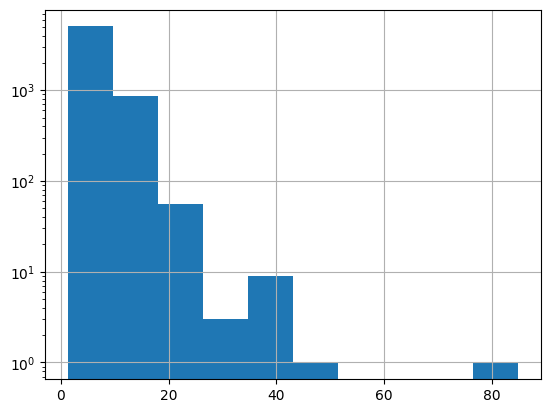

In [48]:
lm_ppls.hist(log=True)
# t.hist()

# clip-graph model

In [9]:
ldr = torch.utils.data.DataLoader(ds, collate_fn=ds.__collate__, batch_size=8)
print(type(cg_model))
print(type(lm_model))
cg_ppls = perplexity(cg_model, ldr, device=device)
cg_ppls = pd.Series(cg_ppls)

<class 'transformers.models.gpt2.modeling_gpt2.GPT2Model'>
<class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>


  0%|          | 0/750 [00:00<?, ?it/s]


AttributeError: 'BaseModelOutputWithPastAndCrossAttentions' object has no attribute 'logits'

In [ ]:
cg_ppls.describe()

In [ ]:
cg_ppls.hist(log=True)

# Test difference

In [ ]:
dat = lm_ppls.to_numpy()[None, :]

res = ss.bootstrap(
    dat,
    np.mean,
    n_resamples=10000,
    
    # ss.bootstrap computes two-tailed intervals,
    # we want a one-tailed test
    confidence_level = 1 - 0.05 * 2,
)

display(
    lm_ppls.mean(),
    cg_ppls.mean(),
    res.confidence_interval,
    (cg_ppls.mean() > res.confidence_interval.high or cg_ppls.mean() < res.confidence_interval.low)
)